In [1]:
from src.utils.Visualisation import plot_ROC_simple
from src.utils.BayesianLabel import BayesianLabeler as Labeller 
from src.utils.FeatureExtractor import *
import pandas as pd 
import numpy as np 
from datetime import timedelta
import matplotlib.pyplot as plt 
from scipy.signal import savgol_filter    


In [2]:
well_code = "BIGL22"

In [3]:
model = FeatureExtractor(well_code)

In [56]:
data = model.data["agg_df"].ROC_VOLTAGE
data = data[model.anomaly_label==0]
def process_fn(x):
    x = np.array(x)[600:]
    x = x[x!=0]
    filter_data = savgol_filter(x, window_length=10, polyorder=1)
    first_derivative = np.gradient(filter_data)
    second_derivative = np.gradient(first_derivative)
    onset_location = np.where((second_derivative>=0.002) & (first_derivative>=0.01))[0]
    if len(onset_location)==0:
        onset_location=1400
    else:
        onset_location=onset_location[0]
    last_gradient = first_derivative[onset_location-10:onset_location]
    return {"filtered_data":filter_data[:onset_location], "first":first_derivative[:onset_location], "second":second_derivative[:onset_location], "last_gradient":last_gradient}
all_data = data.apply(lambda x: process_fn(x)).apply(pd.Series)
label = all_data["last_gradient"].apply(lambda x: x.min()<-0.04)


ValueError: zero-size array to reduction operation minimum which has no identity

In [62]:
np.where(all_data['last_gradient'].apply(lambda x: len(x))==0)

(array([  16,   46,   63,   77,   93,  323,  324,  338,  439,  454,  831,
        1026, 1358, 1457, 1684, 1685, 1705, 1707, 1777, 1861, 2045, 2059,
        2074, 2083], dtype=int64),)

In [66]:
all_data['last_gradient'].index[16]

Timestamp('2016-07-16 00:00:00')

In [41]:
eval=model.evaluate_labeller(label,verbose=True)
set(eval['false_neg']) - set(model.anomaly_label[model.anomaly_label==1].index)

{Timestamp('2022-02-12 00:00:00')}

In [42]:
print(len(eval['false_pos']))
eval["false_pos"]

14


{Timestamp('2016-09-20 00:00:00'),
 Timestamp('2017-03-28 00:00:00'),
 Timestamp('2017-03-29 00:00:00'),
 Timestamp('2017-04-02 00:00:00'),
 Timestamp('2017-04-03 00:00:00'),
 Timestamp('2017-04-04 00:00:00'),
 Timestamp('2017-04-05 00:00:00'),
 Timestamp('2017-04-06 00:00:00'),
 Timestamp('2017-04-07 00:00:00'),
 Timestamp('2017-04-08 00:00:00'),
 Timestamp('2017-04-09 00:00:00'),
 Timestamp('2017-04-10 00:00:00'),
 Timestamp('2021-12-26 00:00:00'),
 Timestamp('2022-03-24 00:00:00')}

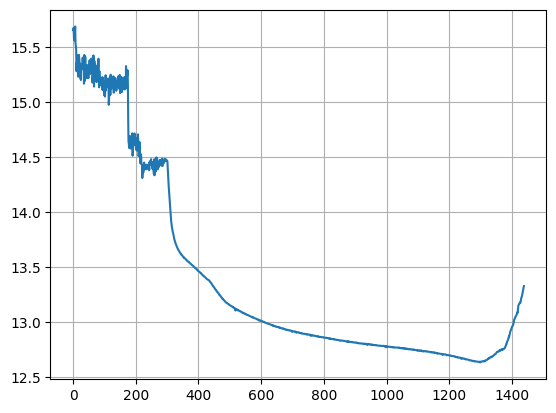

12.63247967


In [67]:
incorrect_date = "2016-07-16"
plot_data = np.array(data.loc[incorrect_date])
plot_data = plot_data[plot_data!=0]
plt.plot(plot_data)
plt.grid()
plt.show()
print(plot_data.min())


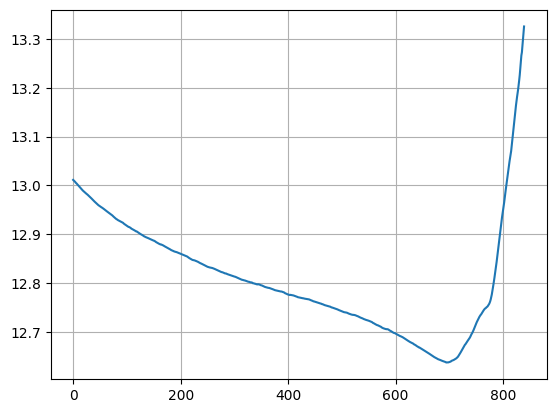

In [68]:
plt.plot(all_data["filtered_data"].loc[incorrect_date])
plt.grid()

0.013575983000000846


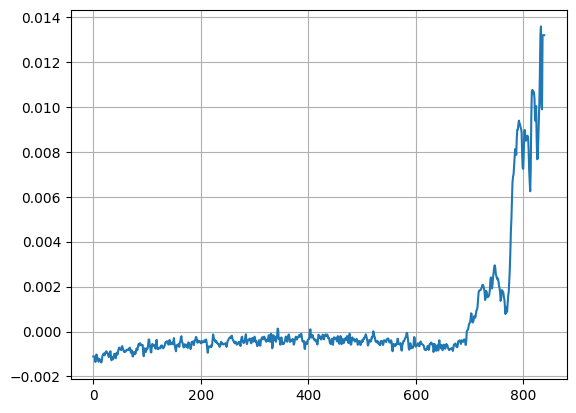

In [69]:
plt.plot(all_data["first"].loc[incorrect_date])
print(max(all_data["first"].loc[incorrect_date]))
plt.grid()

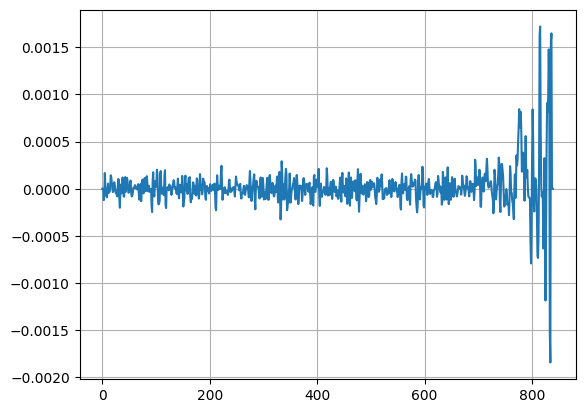

In [70]:
plt.plot(all_data["second"].loc[incorrect_date])
plt.grid()



## Get dawn gradient label 

In [ ]:
gradient_label_df = model.get_dawn_VOLTAGE_drop_failure_label()

In [ ]:
model.evaluate_labeller(gradient_label_df,verbose=False)

## Get dawn data-outage label

In [ ]:
outage_label_df = model.get_data_outage_failure_label()

In [ ]:
model.evaluate_labeller(outage_label_df)

# Get charging fault label 

In [71]:
charging_fault_label = model.get_charging_fault_label()

In [72]:
len(charging_fault_label[charging_fault_label==1])

21

In [73]:
charging_fault_label[charging_fault_label==1]

2016-09-12    1
2017-09-29    1
2020-08-31    1
2020-09-01    1
2020-09-02    1
2020-09-03    1
2020-09-04    1
2020-09-05    1
2020-09-06    1
2020-09-07    1
2020-09-08    1
2020-09-09    1
2020-09-10    1
2021-09-17    1
2022-05-09    1
2022-05-31    1
2022-06-01    1
2022-06-02    1
2022-06-03    1
2022-06-14    1
2022-06-15    1
Name: labels, dtype: object

In [ ]:
charging_fault_label.name = "labels"
plot_ROC_simple(model.data['raw_df'],charging_fault_label.to_frame(),"2017-04-01","2017-06-01")
plt.show()

## Get weather label

In [ ]:
weather_label = model.get_weather_label()


In [ ]:
weather_label[weather_label==1]

In [ ]:
plot_ROC_simple(model.data['raw_df'],weather_label.to_frame(),"2016-07-01","2016-09-09")
plt.show()

## Get data anomaly label

In [ ]:
anomaly_data = model.anomaly_label

In [ ]:
plot_ROC_simple(model.data['raw_df'],anomaly_data.to_frame(),"2016-07-01","2016-09-20")
plt.show()

In [ ]:
x = model.data["agg_df"].loc["2016-08-15"].Mask_ROC_VOLTAGE
[len(list(g)) for k,g in groupby(x) if k==0] 

In [ ]:
plt.plot(model.data["agg_df"].loc["2016-07-03"].ROC_VOLTAGE)

## Get relative minimum VOLTAGE label

In [ ]:
model.interpolated_VOLTAGE

In [ ]:
time_range = pd.date_range("2016-01-01","2017-01-01")

In [ ]:
time_range

In [ ]:
time_range[2] < pd.Timedelta("30d") + time_range[0]

In [ ]:
np.where(time_range<time_range[0]+pd.Timedelta("3d"))[0]

In [137]:
colour_dict = {0:'green',
               1:'purple',
               2:'yellow'}

def get_plot_parameters(gt:pd.DataFrame,pred:pd.DataFrame,target_label:int|Sequence[int])->dict:
    gt_ = gt[gt.labels == target_label].index if isinstance(target_label,int) else gt[gt.labels.isin(target_label)].index
    pred_ = pred[pred.labels==1].index
    label_dict = {}
    for d in sorted(set(gt_)|set(pred_)):
        if d in gt_ and d in pred_: #TP:
            label_dict[d]=0
        elif d in gt_ and d not in pred_: #FN
            label_dict[d]=1
        elif d not in gt_ and d in pred_: #FP
            label_dict[d]=2
    return label_dict

def get_plot_window(label_dict:dict)->list[tuple]:
    date_range = np.array(list(label_dict.keys())).reshape(-1)
    date_parition = []
    current_index = 0 
    while current_index < len(date_range):
        lb = date_range[current_index] - pd.Timedelta("10d")
        ub = date_range[current_index] + pd.Timedelta("10d")
        current_index = np.where(date_range>ub)[0]
        if len(current_index)!=0:
            current_index=current_index[0]
        else:
            current_index=len(date_range)
        date_parition.append([lb,ub])
    return date_parition

def get_diagnostic_plots(raw_df, label_dict, plot_window, window_index, ylim=None):
    label = pd.DataFrame({"labels": label_dict.values()}, index=label_dict.keys()).labels
    num_subplots = 3
    start = plot_window[window_index][0].strftime("%Y-%m-%d")
    end = plot_window[window_index][1].strftime("%Y-%m-%d")
    label=label.loc[start:end]
    fig, ax = plt.subplots(num_subplots, figsize=(35,15), sharex=True)
    ax[0].scatter(raw_df.ROC_VOLTAGE.loc[start:end].index, raw_df.ROC_VOLTAGE.loc[start:end], s=1, c='green')
    ax[1].scatter(raw_df.FLOW.loc[start:end].index, raw_df.FLOW.loc[start:end], s=1, c='green')
    ax[2].scatter(raw_df.PRESSURE_TH.loc[start:end].index, raw_df.PRESSURE_TH.loc[start:end], s=1, c='green')
        
    #Plot label    
    for i in range(len(label)):
        x_start = label.index[i]
        x_end = x_start + timedelta(days=1)
        colour = colour_dict[label[i]]
        ax[0].axvspan(x_start, x_end, ymin=0, ymax=1, color=colour, alpha = 0.5)
        ax[1].axvspan(x_start, x_end, ymin=0, ymax=1, color=colour, alpha = 0.5)
        ax[2].axvspan(x_start, x_end, ymin=0, ymax=1, color=colour, alpha = 0.5)

    if ylim is not None:
        if "ROC_VOLTAGE" in ylim:
            ax[0].set_ylim(ylim["ROC_VOLTAGE"])
        if "FLOW" in ylim:
            ax[1].set_ylim(ylim["FLOW"])
        if "PRESSURE_TH" in ylim:
            ax[2].set_ylim(ylim["PRESSURE_TH"])
            
    ax[0].grid()
    ax[0].set_ylabel("ROC VOLTAGE")
    ax[1].set_ylabel("FLOW")
    ax[2].set_ylabel("PRESSURE_TH")
    
    markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='',ms=8) for color in colour_dict.values()]
    ax[2].legend(markers, ["TP","FN","FP"], numpoints=1,prop={'size': 8})
    return fig
            

In [138]:
label_dict = get_plot_parameters(model.data['label_df'], charging_fault_label.to_frame(), 6)
plot_window = get_plot_window(label_dict)


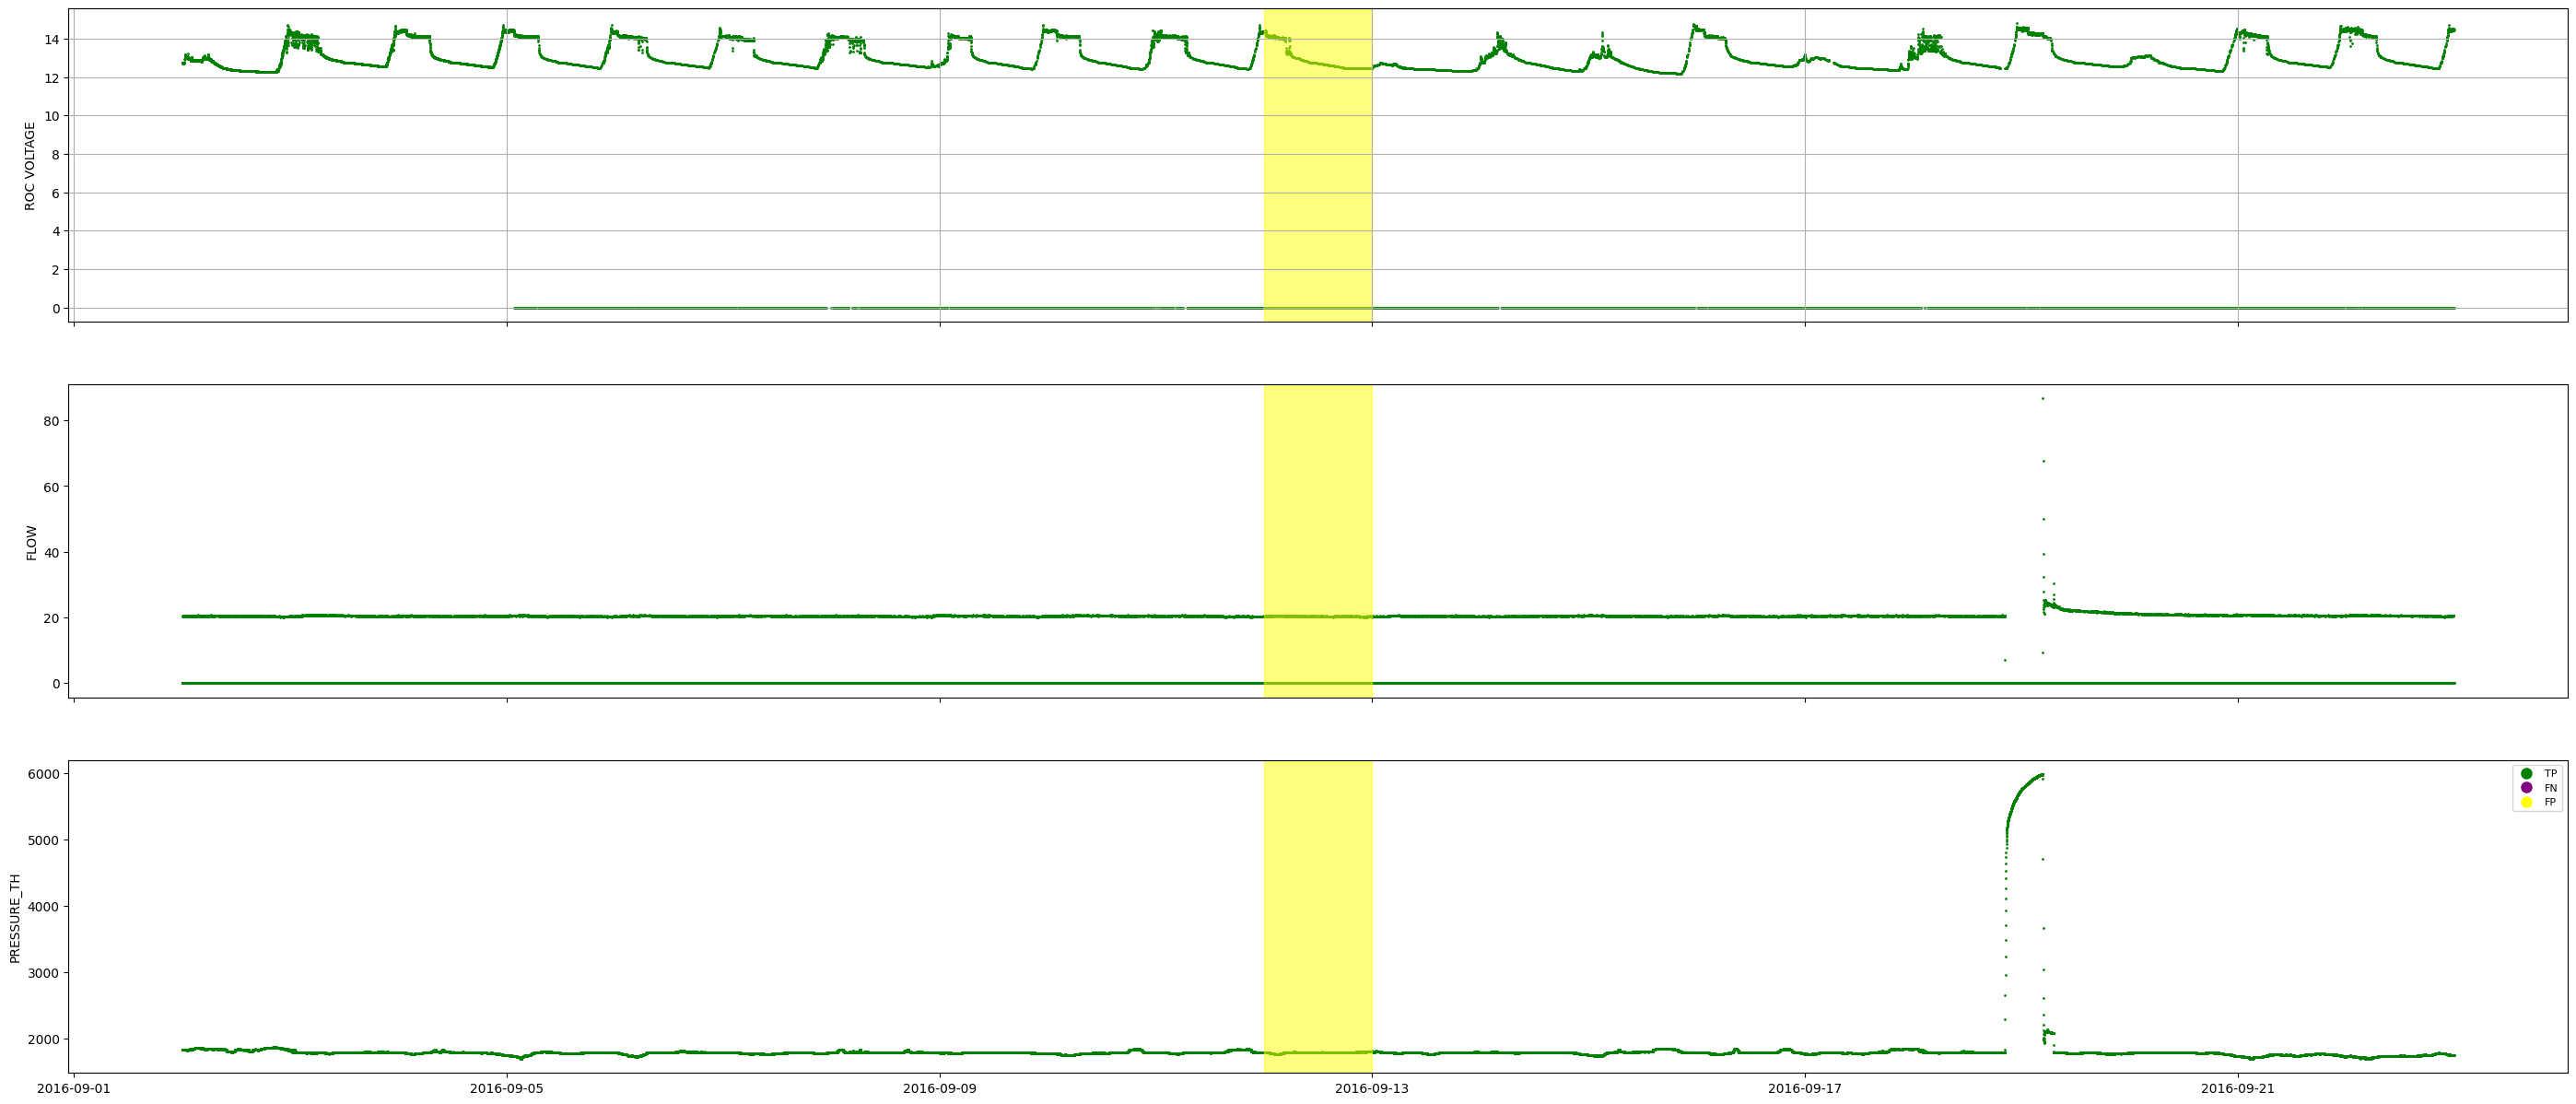

In [139]:
get_diagnostic_plots(model.data['raw_df'],label_dict,plot_window,0)
plt.show()

In [109]:
plot_window[0][0]

Timestamp('2016-08-13 00:00:00')

In [112]:
plot_window[0][1]

Timestamp('2016-10-12 00:00:00')

In [100]:
pd.DataFrame({"labels": label_dict.values()}, index=label_dict.keys())

,labels
2016-09-12,2
2017-09-29,2
2020-08-31,2
2020-09-01,0
2020-09-02,0
2020-09-03,0
2020-09-04,0
2020-09-05,0
2020-09-06,0
2020-09-07,0
